In [ ]:
#default_exp lightning.core

In [ ]:
#export
from typing import Optional, Callable
import albumentations as A
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional.classification import accuracy
from pytorch_lightning import _logger as log

from lib.core import *
from lib.layers import *
from lib.mixmethods import *

In [ ]:
from functools import partial
import timm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

In [ ]:
#export
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]

In [ ]:
#export
class CassavaLightningDataModule(pl.LightningDataModule):
    "lightning-datamodule for cassave leaf disease classification"
    def __init__(self, df_path:str, im_dir:str, curr_fold: int,
                 train_augs: A.Compose, valid_augs: A.Compose, bs: int = 64, 
                 num_workers: int=0):
        
        self.df = load_dataset(df_path, im_dir, curr_fold, True)
        self.curr_fold = curr_fold
        self.train_augs, self.valid_augs = train_augs, valid_augs
        self.bs, self.workers = bs, num_workers
    
    def prepare_data(self):
        log.info(f'Generating data for fold: {self.curr_fold}')
        self.train_df: pd.DataFrame = self.df.loc[self.df['is_valid'] == False]
        self.valid_df: pd.DataFrame = self.df.loc[self.df['is_valid'] == True]
            
        self.train_df = self.train_df.reset_index(inplace=False, drop=True)
        self.valid_df = self.valid_df.reset_index(inplace=False, drop=True)
            
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_ds = ImageClassificationFromDf(self.train_df, self.train_augs)
            self.valid_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)
        if stage == "test" or stage is None:
            self.test_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)
            
    def train_dataloader(self):
        return DataLoader(self.train_ds, shuffle=True, batch_size=self.bs, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.bs, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.bs, num_workers=self.workers)

In [ ]:
def make_show_grid(dl):
    im, batch = next(iter(dl))
    grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(grid);

In [ ]:
#export
class LightningCassava(pl.LightningModule):
    "LightningModule wrapper for `TransferLearningModel`"
    def __init__(self, model: TransferLearningModel = None, 
                 opt_func: Callable = None,
                 lr: float = 1e-03,
                 lr_mult: int = 100,
                 step_after: Optional[str] = None, 
                 frequency: int = 1, 
                 metric_to_track: Optional[str] = None,
                 scheduler: Optional[Callable] = None,
                 loss_func: Callable = LabelSmoothingCrossEntropy(), 
                 mixmethod: Optional[Callable] = None):
        
        super().__init__()
        self.model = model
        
        if isinstance(mixmethod, partial): self.mix_fn = mixmethod()
        else                             : self.mix_fn = mixmethod
        
        self.save_hyperparameters()
        log.info(f'Using {mixmethod}')
        log.info(f'Uses {loss_func}')
        
    def forward(self, xb):  return self.model(xb)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        if self.mix_fn is not None:
            x_mix = self.mix_fn(x, y, self.model)
            y_hat = self(x_mix)
            loss = self.mix_fn.loss(self.hparams.loss_func, y_hat)
        
        else:
            y_hat = self(x)
            loss = self.hparams.loss_func(y_hat, y)
            
        self.log("train_loss", loss, prog_bar=False)
        self.log("epoch_loss", loss, prog_bar=True, logger=False, on_epoch=True, on_step=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.hparams.loss_func(y_hat, y)
        
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy(preds, y)
        
        metrics = {'valid_loss': loss, 'accuracy': acc}
        self.log_dict(metrics, prog_bar=True, logger=True,)
        return metrics
    
    def test_step(self, batch, batch_idx):
        metrics = self.validation_step(batch, batch_idx)
        metrics = {'test_acc': metrics['accuracy'], 'test_loss': metrics['valid_loss']}
        self.log_dict(metrics)
        
    def configure_optimizers(self):
        ps = self.param_list
        param_list = [
            {'params': ps[0], 'lr': self.hparams.lr/self.hparams.lr_mult},
            {'params': ps[1], 'lr': self.hparams.lr}
        ]
        opt = self.hparams.opt_func(param_list)
        
        if self.hparams.scheduler is not None:
            try:
                # for OneCycleLR set the LR so we can use LrFinder
                lr_list = [self.hparams.lr/self.hparams.lr_mult, self.hparams.lr]
                sch = self.hparams.scheduler(opt, max_lr=lr_list, steps_per_epoch=len(self.train_dataloader()))
            except: sch = self.hparams.scheduler(opt)
                
            # convert scheduler to lightning format
            sch = {'scheduler': sch, 
                   'monitor'  : self.hparams.metric_to_track, 
                   'interval' : self.hparams.step_after, 
                   'frequency': self.hparams.frequency}
            
            return [opt], [sch]
        
        else: return [opt]
        
    @property
    def param_list(self):
        return [params(self.model.encoder), params(self.model.fc)]
    
    def save_model_weights(self, path:str):
        state = self.model.state_dict()
        torch.save(state, state)
        log.info(f'weights saved to {path}')
        
    def load_model_weights(self, path:str):
        state_dict = torch.load(path)
        self.model.load_state_dict(state_dict)
        log.info(f'weights loaded from {path}')

In [ ]:
train_augs = A.Compose([
    A.RandomResizedCrop(224, 224, p=1.0),
    A.RandomBrightness(),
    A.HorizontalFlip(),
    A.IAASharpen(),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

valid_augs = A.Compose([
    A.Resize(224, 224, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

csv = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
ims = "../../Datasets/cassava/train_images/"
dm = CassavaLightningDataModule(csv, ims, curr_fold=0, 
                                train_augs=train_augs, valid_augs=valid_augs, 
                                bs=32, num_workers=0)

dm.prepare_data()
dm.setup()
train_dl,valid_dl,test_dl = dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()

Generating data for fold: 0


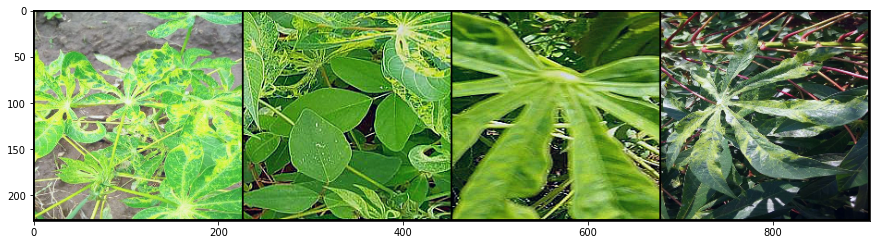

In [ ]:
make_show_grid(train_dl)

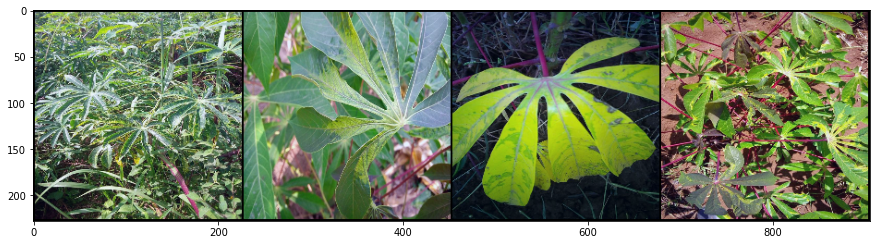

In [ ]:
make_show_grid(valid_dl)

In [ ]:
encoder = timm.create_model('resnet18', pretrained=False)
model = TransferLearningModel(encoder, cut=-2, c=5, act=nn.ReLU(inplace=True))

m = LightningCassava(model=model, lr=1e-02, lr_mult=100,
                opt_func=partial(torch.optim.AdamW, weight_decay=0.01, eps=1e-05), step_after='step',
                scheduler=partial(torch.optim.lr_scheduler.OneCycleLR, epochs=1), 
                mixmethod=partial(Mixup, alpha=0.4), 
                loss_func=LabelSmoothingCrossEntropy(0.1))

trainer = pl.Trainer(callbacks=[pl.callbacks.LearningRateMonitor('step')], max_epochs=1, 
                    gradient_clip_val=0.1, limit_train_batches=0.1, num_sanity_val_steps=0, 
                    limit_val_batches=0.1, limit_test_batches=0.1,)

Using functools.partial(<class 'lib.mixmethods.Mixup'>, alpha=0.4)
Uses LabelSmoothingCrossEntropy()
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(m, datamodule=dm)


  | Name  | Type                  | Params
------------------------------------------------
0 | model | TransferLearningModel | 11.7 M
/Users/ayushman/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/ayushman/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

In [ ]:
trainer.save_checkpoint("example.ckpt")

In [ ]:
synth_model = LightningCassava.load_from_checkpoint("example.ckpt")

Using functools.partial(<class 'lib.mixmethods.Mixup'>, alpha=0.4)
Uses LabelSmoothingCrossEntropy()
